In [1]:
pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

#Connect with google drive
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)



Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
# Getting our images
dataset_train = "/content/drive/MyDrive/Colab Notebooks/Data/train"
dataset_test = "/content/drive/MyDrive/Colab Notebooks/Data/test"
dataset_valid = "/content/drive/MyDrive/Colab Notebooks/Data/valid"

In [4]:
disaster = np.array(list(os.listdir(dataset_train)))

In [5]:
idx_to_name = {i:x for (i,x) in enumerate(disaster)}
name_to_idx = {x:i for (i,x) in enumerate(disaster)}
print(idx_to_name)

{0: 'storm', 1: 'earthquake', 2: 'wildfire', 3: 'flood'}


In [6]:
def get_data_labels(path, disaster, dim):
    data = []
    labels = []

    for nat in disaster:
        imgs = [cv2.resize(cv2.imread(img), dim, interpolation=cv2.INTER_AREA) for img in glob.glob(path + "/" + nat + "/*.jpg")]
        for img in imgs:
            data.append(img)
            labels.append(name_to_idx[nat])
    return np.array(data), np.array(labels)

In [7]:
data_train, labels_train = get_data_labels(dataset_train, idx_to_name.values(), (224,224))
data_test, labels_test = get_data_labels(dataset_test, idx_to_name.values(), (224,224))
data_valid, labels_valid = get_data_labels(dataset_valid, idx_to_name.values(), (224,224))

In [8]:
def normalize(data):
    data = data / 255.0
    data = data.astype('float32')
    return data

def one_hot(labels):
    labels = np.eye(len(np.unique(labels)))[labels]
    return labels

In [9]:
data_train = normalize(data_train)
data_test = normalize(data_test)
data_valid = normalize(data_valid)

In [10]:
labels_train = one_hot(labels_train)
labels_test = one_hot(labels_test)
labels_valid = one_hot(labels_valid)

In [11]:
from tensorflow.keras import layers,models
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation

Average CNN Model

In [12]:
# Creating our Average CNN model
input_shape = (224, 224, 3)

model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dropout (Dropout)           (None, 186624)            0

In [13]:
model1.compile( loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Running our average model with 15 epochs
history1 = model1.fit(data_train, labels_train, epochs=10, validation_data=(data_test, labels_test))

Epoch 1/10
26/26 [==============================] - 15s 116ms/step - loss: 2.1758 - accuracy: 0.4590 - val_loss: 1.2358 - val_accuracy: 0.3905
Epoch 2/10
26/26 [==============================] - 2s 60ms/step - loss: 1.0517 - accuracy: 0.6393 - val_loss: 0.6881 - val_accuracy: 0.8308
Epoch 3/10
26/26 [==============================] - 2s 65ms/step - loss: 0.6370 - accuracy: 0.7761 - val_loss: 1.3523 - val_accuracy: 0.5124
Epoch 4/10
26/26 [==============================] - 2s 65ms/step - loss: 0.6201 - accuracy: 0.7910 - val_loss: 0.3099 - val_accuracy: 0.9328
Epoch 5/10
26/26 [==============================] - 2s 66ms/step - loss: 0.3943 - accuracy: 0.8669 - val_loss: 0.3674 - val_accuracy: 0.8657
Epoch 6/10
26/26 [==============================] - 2s 61ms/step - loss: 0.3127 - accuracy: 0.9005 - val_loss: 0.1816 - val_accuracy: 0.9490
Epoch 7/10
26/26 [==============================] - 2s 62ms/step - loss: 0.2672 - accuracy: 0.9279 - val_loss: 0.1379 - val_accuracy: 0.9652
Epoch 8/10


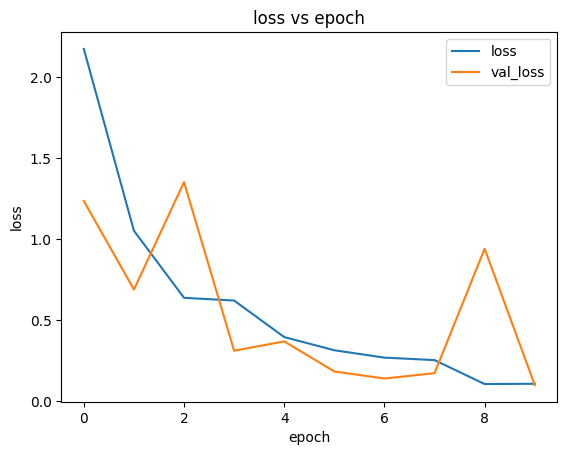

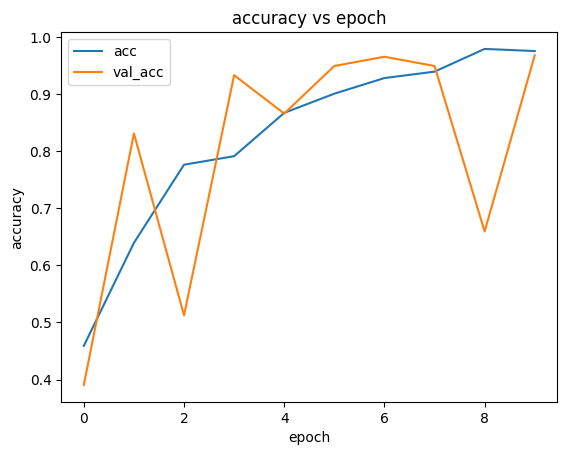

In [15]:
# Plotting the loss and accuracy vs epochs graphs

import matplotlib.pyplot as plt
#Loss
plt.plot(history1.history['loss'],label='loss')
plt.plot(history1.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend()
plt.show()
#Accuracy
plt.plot(history1.history['accuracy'],label='acc')
plt.plot(history1.history['val_accuracy'],label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs epoch')
plt.legend()
plt.show()

VGG16 Model

In [16]:
# Creating our VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [17]:
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
nr_disaster = 4

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add our new softmax layer with 3 hidden units
x = Dense(nr_disaster, activation='softmax', name='softmax')(x)

In [19]:
# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
new_model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='disaster.model.hdf5', save_best_only=True)

In [21]:
# Running our VGG16 model with 7 epochs
# Beware VGG16 is a very complex model
# You can run more epochs.However it is very time consuming
history = new_model.fit(data_train, labels_train, steps_per_epoch=10,
validation_data=(data_test, labels_test), validation_steps=3, epochs=7, verbose=1, callbacks=[checkpointer])


Epoch 1/7
10/10 [==============================] - 53s 5s/step - loss: 8.7043 - accuracy: 0.5124 - val_loss: 4.3557 - val_accuracy: 0.6617
Epoch 2/7
10/10 [==============================] - 8s 899ms/step - loss: 2.0972 - accuracy: 0.8209 - val_loss: 1.8843 - val_accuracy: 0.8507
Epoch 3/7
10/10 [==============================] - 9s 908ms/step - loss: 1.0492 - accuracy: 0.8918 - val_loss: 0.4764 - val_accuracy: 0.9440
Epoch 4/7
10/10 [==============================] - 8s 894ms/step - loss: 0.3299 - accuracy: 0.9639 - val_loss: 0.1332 - val_accuracy: 0.9764
Epoch 5/7
10/10 [==============================] - 6s 676ms/step - loss: 0.0585 - accuracy: 0.9851 - val_loss: 0.0309 - val_accuracy: 0.9925
Epoch 6/7
10/10 [==============================] - 8s 898ms/step - loss: 0.0215 - accuracy: 0.9950 - val_loss: 0.0024 - val_accuracy: 0.9988
Epoch 7/7
10/10 [==============================] - 7s 679ms/step - loss: 0.0019 - accuracy: 0.9988 - val_loss: 3.2509e-04 - val_accuracy: 1.0000


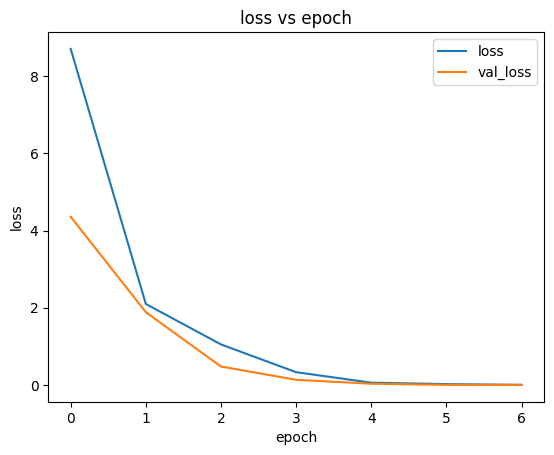

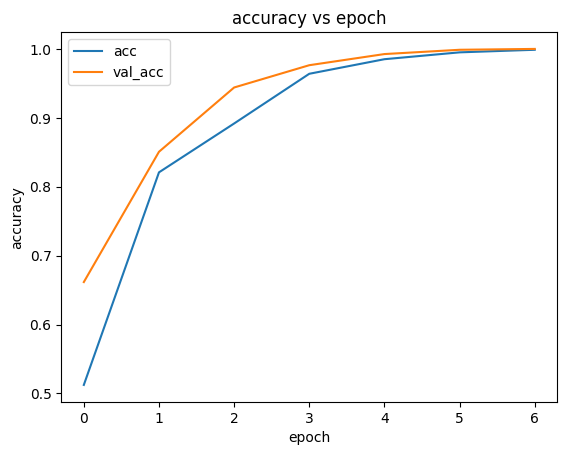

In [22]:
# Plotting the loss and accuracry vs epochs graphs
import matplotlib.pyplot as plt
#Loss
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs epoch')
plt.legend()
plt.show()
#Accuracy
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs epoch')
plt.legend()
plt.show()

In [23]:
# Saving our model
new_model.save('/content/drive/MyDrive/Colab Notebooks/Model')

In [24]:
# Loading our model
model_load = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Model')

In [25]:
# Getting our loss and accuracy
score = model_load.evaluate(data_valid,labels_valid, verbose = 0)
print("Validation Loss:", score[0])
print("Validation Accuracy:", score[1])

Validation Loss: 0.0003610115381889045
Validation Accuracy: 1.0


In [26]:
# Getting our images to test our VGG16 model
test_img_1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Data/img/disaster1.jpg')
test_img_2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Data/img/disaster2.jpg')
test_img_3 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Data/img/disaster3.jpg')
test_img_4 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Data/img/disaster4.jpg')

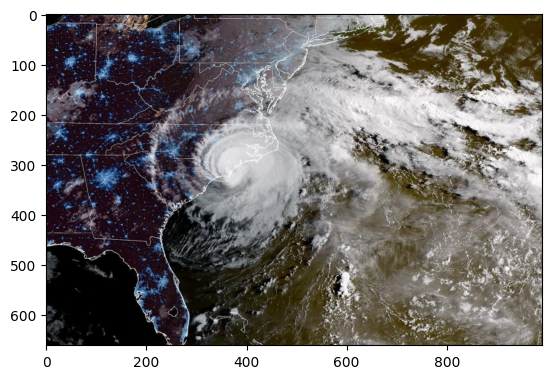

In [27]:
# Showing an image we will test with
plt.imshow(test_img_1)

In [28]:
test_img_1.shape

(661, 991, 3)

In [29]:
# Resizing our images
test_img_1 = cv2.resize(test_img_1,(224,224))
test_img_2 = cv2.resize(test_img_2,(224,224))
test_img_3 = cv2.resize(test_img_3,(224,224))
test_img_4 = cv2.resize(test_img_4,(224,224))

In [30]:
# Reshaping our images
test_1 = test_img_1.reshape((1,224,224,3))
test_2 = test_img_2.reshape((1,224,224,3))
test_3 = test_img_3.reshape((1,224,224,3))
test_4 = test_img_4.reshape((1,224,224,3))

In [31]:
# Printing out the labels and the natural disasters
print(idx_to_name)

{0: 'storm', 1: 'earthquake', 2: 'wildfire', 3: 'flood'}


Now we will test our model with the newly transformed images

For the following image
here is its predicted category
{0: 'storm', 1: 'earthquake', 2: 'wildfire', 3: 'flood'}
1/1 [==============================] - 1s 755ms/step
[[1. 0. 0. 0.]]


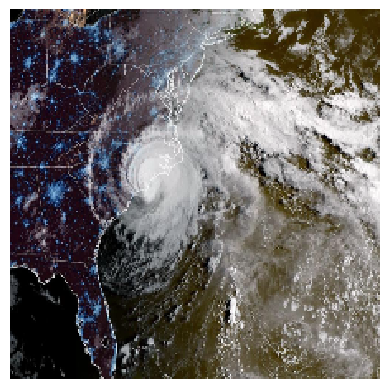

In [32]:
print("For the following image")
print("here is its predicted category")
print(idx_to_name)
img = plt.imshow(test_img_1, interpolation='nearest')
img.set_cmap('hot')
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
print(model_load.predict(test_1))

For the following image
here is its predicted category
{0: 'storm', 1: 'earthquake', 2: 'wildfire', 3: 'flood'}
1/1 [==============================] - 0s 23ms/step
[[0. 1. 0. 0.]]


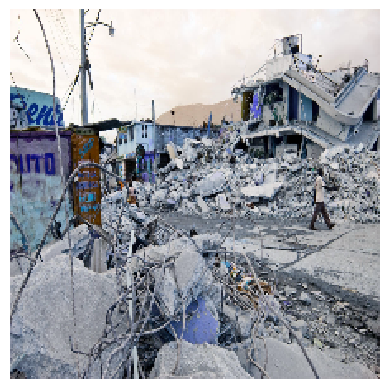

In [33]:
print("For the following image")
print("here is its predicted category")
print(idx_to_name)
img = plt.imshow(test_img_2, interpolation='nearest')
img.set_cmap('hot')
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
print(model_load.predict(test_2))

For the following image
here is its predicted category
{0: 'storm', 1: 'earthquake', 2: 'wildfire', 3: 'flood'}
1/1 [==============================] - 0s 35ms/step
[[0. 0. 0. 1.]]


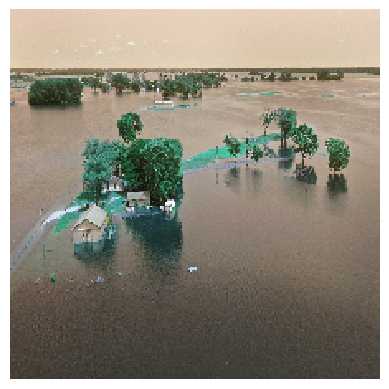

In [34]:
print("For the following image")
print("here is its predicted category")
print(idx_to_name)
img = plt.imshow(test_img_3, interpolation='nearest')
img.set_cmap('hot')
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
print(model_load.predict(test_3))

For the following image
here is its predicted category
{0: 'storm', 1: 'earthquake', 2: 'wildfire', 3: 'flood'}
1/1 [==============================] - 0s 28ms/step
[[0. 0. 1. 0.]]


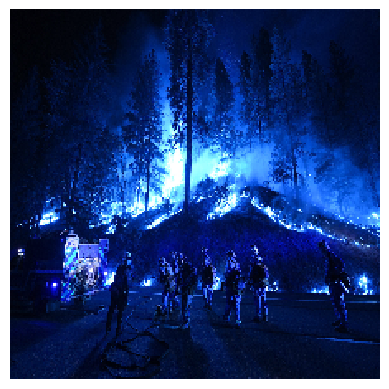

In [35]:
print("For the following image")
print("here is its predicted category")
print(idx_to_name)
img = plt.imshow(test_img_4, interpolation='nearest')
img.set_cmap('hot')
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
print(model_load.predict(test_4))